# Data exploration on PAMI interim dataset
In this notebook we will understand the main features of the dataset and the distribution of the data. We will use the generated interim dataset generated from the raw data, as in this format it will be easier to work with.



## 0.Interim data loading
First we will load the libraries needed to load the interim data and check it is loaded correctly.

In [1]:
import pandas as pd
from pathlib import Path
import os
from src import INTERIM_DATA_DIR, INTERIM_COLUMNS

Now we will load the interim data and check the archives found in the folder. We expect to have three archives: `train.pkl`, `test.pkl` and `validation.pkl`, corresponding to the train, test and validation sets respectively given by the raw data annotations. 

In [2]:
annotations_path = Path(os.path.join(INTERIM_DATA_DIR, 'annotations'))

annotations = {}
for data_split in os.listdir(annotations_path):
    if data_split.endswith('.pkl'):
        file = os.path.join(annotations_path, data_split)
        data_part_name = data_split.split('.')[0]
        annotations[data_part_name] = pd.read_pickle(file)
print("The annotations found are for the datasplits:", list(annotations.keys()))
print(annotations.keys())

The annotations found are for the datasplits: ['test', 'train', 'val']
dict_keys(['test', 'train', 'val'])


We will order them into the following structure: train, validation and test.


In [3]:
# Sort the dictionary based on the order_list
desired_order = ['train', 'val', 'test']
annotations = dict(sorted(annotations.items(), key=lambda x: desired_order.index(x[0])))
print("The annotations order:", list(annotations.keys()))

The annotations order: ['train', 'val', 'test']


The standard column format (further on we will check if it is) for all annotations is:

In [4]:
print("Standard column format:", INTERIM_COLUMNS)

Standard column format: ['path', 'orig_db', 'img_size', 'people', 'bbox', 'label_cat', 'label_cont', 'gender', 'age']


The total number of images and people is:

In [5]:
annotated_emotions = []
total_photos = 0
total_people = 0
for data_split in annotations.keys():
    total_photos += len(annotations[data_split])
    for photo_idx in range(len(annotations[data_split])):
        total_people += annotations[data_split].loc[photo_idx]['people']

print ("Total number of photos:", total_photos)
print ("Total number of people:", total_people)

Total number of photos: 23554
Total number of people: 34320


The number of photos does not coincide with the paper, but the number of people does, so maybe the number of photos is wrong in the paper. Now we will look a set of example entries:

In [6]:
annotations['train'].head()

path orig_db    img_size  people  \
0    mscoco/COCO_val2014_000000562243.jpg  mscoco  [640, 640]       1   
1  mscoco/COCO_train2014_000000288841.jpg  mscoco  [640, 480]       1   
2    mscoco/COCO_val2014_000000558171.jpg  mscoco  [640, 480]       1   
3  mscoco/COCO_train2014_000000369575.jpg  mscoco  [480, 640]       1   
4  mscoco/COCO_train2014_000000213009.jpg  mscoco  [500, 333]       1   

                     bbox                              label_cat  \
0    [[86, 58, 564, 628]]     [[Disconnection, Doubt/Confusion]]   
1  [[485, 149, 605, 473]]                       [[Anticipation]]   
2   [[305, 92, 461, 465]]  [[Engagement, Excitement, Happiness]]   
3   [[221, 63, 448, 372]]                 [[Aversion, Pleasure]]   
4   [[44, 143, 150, 288]]             [[Confidence, Excitement]]   

     label_cont gender  age  
0   [[5, 3, 9]]    [M]  [A]  
1   [[6, 4, 7]]    [M]  [A]  
2   [[7, 8, 8]]    [M]  [T]  
3   [[8, 9, 8]]    [M]  [K]  
4  [[7, 9, 10]]    [M]  [A]

### 0.1 Sanity checks
We will look for NAN values and check if there are any in the dataset.

## 1.Emotions analysis and exploration:

### 1.1. Categorical annotations analysis and exploration

The main goal of this section is to understand the distribution of the categorical annotations in the dataset. We will check the distribution of the annotations in the whole dataset. The annotated categorical annotations are (we take train datasplit as example)

In [7]:
annotated_emotions = []
for emotions_annotated in annotations['train']['label_cat']:
    for person in emotions_annotated:
        for emotion in person:
            if emotion not in annotated_emotions:
                annotated_emotions.append(emotion)


print("In total, there are", len(annotated_emotions), "emotions annotated.")
print("The emotions found are:", annotated_emotions)

In total, there are 26 emotions annotated.
The emotions found are: ['Disconnection', 'Doubt/Confusion', 'Anticipation', 'Engagement', 'Excitement', 'Happiness', 'Aversion', 'Pleasure', 'Confidence', 'Peace', 'Fatigue', 'Pain', 'Sadness', 'Sensitivity', 'Suffering', 'Sympathy', 'Fear', 'Yearning', 'Disquietment', 'Esteem', 'Annoyance', 'Affection', 'Anger', 'Disapproval', 'Embarrassment', 'Surprise']


#### 1.1.1. Number of emotions felt per each person
First we will compute the necessary metrics to see the distribution of the number of emotions felt per each person.

In [8]:
import altair as alt 
from itertools import combinations
import numpy as np
alt.data_transformers.disable_max_rows() #we delete the upper bound of entries in altair
emotions_per_person = {}
emotion_count = {}
for data_split in annotations.keys():
    for photo_idx in range(len(annotations[data_split])):
        for person in range (len(annotations[data_split].loc[photo_idx, "label_cat"])):
            emotions = annotations[data_split].loc[photo_idx, "label_cat"][person]
            num_emotions = len(emotions)
            if num_emotions in emotions_per_person.keys():
                emotions_per_person[num_emotions] += 1
            else:
                emotions_per_person[num_emotions] = 1

            for emotion in annotations[data_split].loc[photo_idx, "label_cat"][person]:
                if emotion in emotion_count.keys():
                    emotion_count[emotion] += 1
                else:
                    emotion_count[emotion] = 1



Now we analyze the number of emotions per photo:

In [9]:
# Convert dictionary to pandas DataFrame
df = pd.DataFrame(list(emotions_per_person.items()), columns=['Number of emotions', 'Number of people'])

# Compute the average number of emotions per person
average_emotions = (df['Number of emotions'] * df['Number of people']).sum() / df['Number of people'].sum()



bar_chart = alt.Chart(df).mark_bar(color='steelblue', size=15).encode(
    x=alt.X('Number of emotions', title='Number of emotions'),
    y='Number of people'
).properties(
    title = alt.TitleParams(text = 'Number of emotions felt per each person', fontSize=16),
    width = 300,
    height = 400
)

# The expected value
average_line = alt.Chart(df).mark_rule(color='black').encode(
    x='average:Q',
    size=alt.value(2)
).transform_calculate(
    average=str(average_emotions)
)

# Text to show the value of the average
average_text = alt.Chart(df).mark_text(
    align='left',
    baseline='line-top',
    dx=7,  # Desplazar el texto a la derecha para que no se superponga con la línea
    dy=-100
).encode(
    x=alt.X('average:Q', title =''),
    text=alt.value('Average: ' + str(round(average_emotions, 2)))  # Redondear el valor promedio a 2 decimales
).transform_calculate(
    average=str(average_emotions)
)

# Superponer el gráfico de barras, la línea horizontal y la anotación de texto
chart = bar_chart + average_line + average_text

chart

alt.LayerChart(...)

We can observe that many people has only one or two emotions per photo, but there are also people with more than 10 emotions per photo. This heavily weighted distribution towards the left will be important to take into account when training the model, as the model will try to predict around 2 or 3 emotions, and will have more difficulties with the less common ones above 8 as they are less frequent in the dataset.

In [10]:
# Repeat the number of emotions for each person
emotions_repeated = np.repeat(df['Number of emotions'], df['Number of people'])

# Compute the quantiles of this new list
quantiles = np.quantile(emotions_repeated, [.25, .5, .75])

print("The Q1 quantile (25%) is located at:", quantiles[0])
print("The Q2 quantile (50%) or median is located at:", quantiles[1])
print("The Q3 quantile (75%) is located at:", quantiles[2])

The Q1 quantile (25%) is located at: 1.0
The Q2 quantile (50%) or median is located at: 2.0
The Q3 quantile (75%) is located at: 4.0


We can see that less than 5% of the entries have 8 or more emotions per person. 

In [11]:
number_of_emotions = 8
probability = len(emotions_repeated[emotions_repeated >= number_of_emotions]) / len(emotions_repeated) 
print("The probability to have", number_of_emotions, "or more emotions is:",probability*100, "%")

The probability to have 8 or more emotions is: 2.534965034965035 %


#### 1.1.2. Emotions distribution

Now we analyze the occurrence of all the emotions in the dataset:

In [12]:
# Convert dictionary to pandas DataFrame
# Ordenar las claves por valor en orden descendente
sorted_keys = sorted(emotion_count, key=emotion_count.get, reverse=True)
df = pd.DataFrame(list(emotion_count.items()), columns=['Categorical emotion', 'Number of people who felt it'])

bar_chart = alt.Chart(df).mark_bar(color='steelblue', size=15).encode(
    x=alt.X('Categorical emotion:O', sort = sorted_keys, axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('Number of people who felt it:Q')
).properties(
    title = alt.TitleParams(text = 'Emotions categories felt across all people', fontSize=16),
    width = 800,
    height = 400
)
bar_chart

alt.Chart(...)

We can observe that the label distribution is not uniform. This is expected, as there are many emotions that has less ocurrences than others. We will need to take care of this when training the model, as it could be biased towards the most common emotions.

We can also observe how the most usual emotion felt is engagement. We will take a closer look, to see the distribution of it to see if it's the only emotion felt or there are more:

In [13]:
emotions_per_person = {} # Dictionary to store the number of emotions per person
selected_emotion = "Engagement" # We focus on the engagement emotion

for data_split in annotations.keys():
    for photo_idx in range(len(annotations[data_split])):
        for person in range (len(annotations[data_split].loc[photo_idx, "label_cat"])):
            emotions = annotations[data_split].loc[photo_idx, "label_cat"][person]
            num_emotions = len(emotions)
            if selected_emotion in emotions: # We filter by the selected emotion we are focusing
                if num_emotions in emotions_per_person.keys():
                    emotions_per_person[num_emotions] += 1
                else:
                    emotions_per_person[num_emotions] = 1

Now we will plot the results:

In [14]:
# Convert dictionary to pandas DataFrame
df = pd.DataFrame(list(emotions_per_person.items()), columns=['Number of emotions', 'Number of people'])

bar_chart = alt.Chart(df).mark_bar(color='steelblue', size=15).encode(
    x='Number of emotions',
    y='Number of people'
).properties(
    title = alt.TitleParams(text = 'Number of emotions felt per each person that has \'Engagement\'', fontSize=16),
    width = 300,
    height = 400
)
bar_chart

alt.Chart(...)

We can observe that there are 5000 people that is labeled only as engagement. So we must take this into account when we are training the model and we must be careful with the results. Some data augmentation or label balance techniques could be useful to solve this problem.

#### 1.1.3. Co-occurrence matrix

We will now compute the co-occurrence matrix to see the distribution of the emotions felt together.This will be useful to see if there are emotions that are usually felt together or not and establish some relations between them.

First I import the needed libraries:

In [15]:
import itertools
import collections

Now we compute all the pairs, and add count them to add them to the co-occurrence matrix:

In [16]:
list_pairs = []
for data_split in annotations.keys():
    for photo_idx in range(len(annotations[data_split])):
        for person in range (len(annotations[data_split].loc[photo_idx, "label_cat"])):
            emotions = annotations[data_split].loc[photo_idx, "label_cat"][person]
            pairs = list(itertools.product(emotions, repeat=2))
            list_pairs.extend(pairs)

# Count the occurrences of each pair
count = collections.Counter(list_pairs)
    
# Convert the count to a DataFrame
co_occurrence_df = pd.DataFrame.from_records(list(count.items()), columns=['pair', 'count'])
# Split the pair into two columns
co_occurrence_df[['EmotionA', 'EmotionB']] = pd.DataFrame(co_occurrence_df['pair'].tolist(), index=co_occurrence_df.index)
# Drop the 'pair' column
co_occurrence_df = co_occurrence_df.drop(columns='pair')
# Reorder the columns to move 'count' to the end
co_occurrence_df = co_occurrence_df[['EmotionA', 'EmotionB', 'count']]

co_occurrence_df = co_occurrence_df.loc[co_occurrence_df['EmotionA'] != 'NA'] # Remove the NA values

max_value_diff = co_occurrence_df.loc[co_occurrence_df['EmotionA'] != co_occurrence_df['EmotionB'], 'count'].max() # to set color range

print(co_occurrence_df)

            EmotionA         EmotionB  count
0      Disconnection    Disconnection   3521
1      Disconnection  Doubt/Confusion    562
2    Doubt/Confusion    Disconnection    562
3    Doubt/Confusion  Doubt/Confusion   2132
4       Anticipation     Anticipation  11786
..               ...              ...    ...
671            Peace            Anger     16
672        Affection            Anger     26
673            Anger        Affection     26
674         Pleasure          Sadness     32
675          Sadness         Pleasure     32

[676 rows x 3 columns]


Now we will plot the result. We will use a heatmap to see the distribution of the emotions felt together. We set the max value to the maximum number of co-occurrences between different emotions, this way we can focus on the information of different co-occurrences (as the emotion ocurrences are detailed in the previous sections and make this information harder to see):

In [17]:
# Crear una selección interactiva
selection = alt.selection_single()
selection2 = alt.selection_multi(
    fields = ['EmotionA','EmotionB'],
    empty = 'none' # empty selection matches no points
)
# Crear un gráfico de calor
heatmap = alt.Chart(co_occurrence_df).mark_rect(stroke='black').encode(
    x=alt.X('EmotionA:O', sort='ascending', title = 'Emotion A category'),
    y=alt.Y('EmotionB:O', sort='ascending', title = 'Emotion B category'),
    color = alt.condition(
        alt.datum.EmotionA != alt.datum.EmotionB,  # Condición para las celdas de la diagonal
        alt.Color('count:Q', scale=alt.Scale(scheme='blues', domainMax = max_value_diff)),  # Paleta de colores 'viridis'
        alt.value('black')  # Color si la condición es falsa
    ),
    tooltip=['EmotionA', 'EmotionB', 'count']
)

# Configure text
text = alt.Chart(co_occurrence_df).mark_text(baseline='middle').encode(
    x= alt.X('EmotionA:O', sort='ascending'),
    y=alt.Y('EmotionB:O', sort='ascending'),
    text = 'count:Q',
    color = alt.value ("black"),
    opacity = alt.condition(selection2, alt.value(1),alt.value(0))
)


coocurrence_plot = heatmap + text
coocurrence_plot.properties(
    title = alt.TitleParams(text = 'Co-occurrence of emotions', fontSize=16),
    width = 800,
    height = 800
).add_selection(
    selection,
    selection2
)

c:\Users\arman\Desktop\emotion_recognition\env\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
c:\Users\arman\Desktop\emotion_recognition\env\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
c:\Users\arman\Desktop\emotion_recognition\env\lib\site-packages\altair\vegalite\v5\api.py:387: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
c:\Users\arman\Desktop\emotion_recognition\env\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.LayerChart(...)

We can see that there are some emotions that are heavily related, as they have a great value on the co-occurrence matrix. For example, we have engagement and excitement, which are usually felt together. We can also see that there are some emotions that are not usually felt together, like sadness and excitement. This is expected, as they are opposite emotions. We will need to keep this in mind as the model will try to predict the emotions felt together, and it will be easier to predict the emotions that are usually felt together. 

For this reason now we normalize each row of the co-occurrence matrix to see the the conditioned probability. This will help us to see the probability of each emotion given another emotion. This way we can focus on the emotions that does not have as much entries and see how given a emotion (y axis), the probability of another emotion is affected (x axis).

In [18]:
total_counts = co_occurrence_df.loc[co_occurrence_df['EmotionA'] == co_occurrence_df['EmotionB'], ['EmotionA', 'count']]
total_counts['count_total'] = total_counts['count'].astype(int)  # Convert 'count' column to integers
total_counts = total_counts.drop(columns='count')  # Drop the 'count' column

# Merge co_occurrence_df with total_counts
co_occurrence_conditioned_df = pd.merge(co_occurrence_df, total_counts, on='EmotionA', how='left')
co_occurrence_conditioned_df['conditioned_prob'] = co_occurrence_conditioned_df['count'] / co_occurrence_conditioned_df['count_total']
co_occurrence_conditioned_df = co_occurrence_conditioned_df.drop(columns=['count', 'count_total'])

print(co_occurrence_conditioned_df)

            EmotionA         EmotionB  conditioned_prob
0      Disconnection    Disconnection          1.000000
1      Disconnection  Doubt/Confusion          0.159614
2    Doubt/Confusion    Disconnection          0.263602
3    Doubt/Confusion  Doubt/Confusion          1.000000
4       Anticipation     Anticipation          1.000000
..               ...              ...               ...
671            Peace            Anger          0.004684
672        Affection            Anger          0.009503
673            Anger        Affection          0.051383
674         Pleasure          Sadness          0.005940
675          Sadness         Pleasure          0.032193

[676 rows x 3 columns]


Now we plot the result.

In [19]:
# Crear una selección interactiva
selection = alt.selection_multi(
    fields = ['EmotionA'],
)
selection2 = alt.selection_multi(
    fields = ['EmotionA'],
    empty = 'none' # empty selection matches no points
)

tooltip=[
    {'field': 'EmotionA', 'title': 'Emotion A'},
    {'field': 'EmotionB', 'title': 'Emotion B'},
    {'field': 'conditioned_prob', 'title': 'Conditioned probability B|A'}
]
# Crear un gráfico de calor
heatmap = alt.Chart(co_occurrence_conditioned_df).mark_rect(stroke='black').encode(
    x=alt.X('EmotionB:O', sort='ascending', title = 'Emotion B'),
    y=alt.Y('EmotionA:O', sort='ascending', title = 'Emotion A'),
    color = alt.condition(selection, alt.Color('conditioned_prob:Q',
              title = 'Emotion A conditioned to B probability',
              scale = alt.Scale(scheme='oranges'), legend = alt.Legend(titleFontSize = 14, labelFontSize=12)), alt.value('grey')),
    opacity = alt.condition(selection, alt.value(1), alt.Opacity('conditioned_prob:Q')),
    tooltip=tooltip
)

# Crear el segundo gráfico de calor
heatmap2 = alt.Chart(co_occurrence_conditioned_df).mark_rect().encode(
    x= alt.X('EmotionB:O', sort='ascending'),
    y=alt.Y('EmotionA:O', sort='ascending'),
    color=alt.condition(
        alt.datum.EmotionB == alt.datum.EmotionA,  # Condición para las celdas de la diagonal
        alt.value('black'),  # Color si la condición es verdadera
        alt.value('transparent')  # Color si la condición es falsa
    )
)

# Crear el segundo gráfico de calor
heatmap3 = alt.Chart(co_occurrence_conditioned_df).mark_rect().encode(
    x= alt.X('EmotionB:O', sort='ascending'),
    y=alt.Y('EmotionA:O', sort='ascending'),
    color=alt.condition(
        alt.datum.EmotionB == alt.datum.EmotionA,  # Condición para las celdas de la diagonal
        alt.value('black'),  # Color si la condición es verdadera
        alt.value('transparent')  # Color si la condición es falsa
    )
)

# Configure text
text = alt.Chart(co_occurrence_conditioned_df).mark_text(baseline='middle').encode(
    x= alt.X('EmotionB:O', sort='ascending'),
    y=alt.Y('EmotionA:O', sort='ascending'),
    text = alt.Text('conditioned_prob:Q', format='.2f'),
    color = alt.value ("black"),
    opacity = alt.condition(selection2, alt.value(1),alt.value(0))
)


coocurrence_plot = heatmap + heatmap2 + heatmap3 + text
coocurrence_plot.properties(
    title = alt.TitleParams(text = 'Probability of appearing the Emotion B conditioned to Emotion A', fontSize=16),
    width = 800,
    height = 800
).add_selection(
    selection,
    selection2
)

c:\Users\arman\Desktop\emotion_recognition\env\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
c:\Users\arman\Desktop\emotion_recognition\env\lib\site-packages\altair\vegalite\v5\api.py:387: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(


c:\Users\arman\Desktop\emotion_recognition\env\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.LayerChart(...)

We can observe that the most probable variable is engagement, this is expected as it is the most common entry in the dataset. 

If you want more information about the associated color of each emotion, you can check the section 3, as it needed lot of time to be executed. 

### 1.2. Continuous annotations analysis and exploration

To do that, first we will analize the general distribution continuous annotations. The continuous annotations are:
1. Valence: The valence of the emotion felt. It is a value between 1 and 10, where 0 is the most negative valence and 10 is the most positive valence.
2. Arousal: The arousal of the emotion felt. It is a value between 1 and 10, where 0 is the most calm arousal and 10 is the most excited arousal.
3. Dominance: The dominance of the emotion felt. It is a value between 1 and 10, where 0 is the most submissive dominance and 10 is the most dominant dominance.

### 1.2.1. General distribution:
Now we will compute the necessary metrics to see the distribution of the continuous annotations in the dataset.

In [20]:
continious_annotations = []
for data_split in annotations.keys():
    for photo_idx in range(len(annotations[data_split])):
        for person in range (len(annotations[data_split].loc[photo_idx, "label_cont"])):
            labels = {'valence': annotations[data_split].loc[photo_idx, "label_cont"][person][0],
             'arousal': annotations[data_split].loc[photo_idx, "label_cont"][person][1],
             'dominance': annotations[data_split].loc[photo_idx, "label_cont"][person][2]}
            continious_annotations.append(labels)
            
# Create a dataframe with sample data
continious_annotations = pd.DataFrame(continious_annotations).dropna()
# Select only numeric columns
print(continious_annotations.head())

   valence  arousal  dominance
0      5.0      3.0        9.0
1      6.0      4.0        7.0
2      7.0      8.0        8.0
3      8.0      9.0        8.0
4      7.0      9.0       10.0


The mean and standard deviation values (std is the square root of the variance) of the continuous annotations are:

In [21]:
# Compute the mean for each column
mean = continious_annotations.mean()

# Compute the standard deviation for each column
std_dev = continious_annotations.std()

print("Mean:\n", mean, sep ='')
print("\nStandard Deviation:\n", std_dev, sep ='')

Mean:
valence      5.984041
arousal      5.613262
dominance    6.483260
dtype: float64

Standard Deviation:
valence      1.315816
arousal      1.916780
dominance    1.675244
dtype: float64


In [22]:
# Transform the data for ridge plot
continious_annotations_rowed = pd.melt(continious_annotations, var_name='Variable', value_name='Value')

In [23]:
# Define the range
value_range = [continious_annotations_rowed['Value'].min(), continious_annotations_rowed['Value'].max()]

# Calculate the maximum count across all variables
max_count = max(
    continious_annotations_rowed[continious_annotations_rowed['Variable'] == 'valence']['Value'].value_counts().max(),
    continious_annotations_rowed[continious_annotations_rowed['Variable'] == 'arousal']['Value'].value_counts().max(),
    continious_annotations_rowed[continious_annotations_rowed['Variable'] == 'dominance']['Value'].value_counts().max()
)

# Create a histogram
valence_hist = alt.Chart(continious_annotations_rowed).mark_bar(color = "orange", width= 20).encode(
    alt.X("Value", scale=alt.Scale(domain=value_range)),
    alt.Y('count()', scale=alt.Scale(domain=[0, max_count])),
).transform_filter(
    alt.datum.Variable == 'valence'
).properties(
    title = alt.TitleParams(text = 'Valence Distribution', fontSize=16),
    width = 400,
    height = 400
)

# Create a histogram
arousal_hist = alt.Chart(continious_annotations_rowed).mark_bar(color = "orange", width= 20).encode(
    alt.X("Value", scale=alt.Scale(domain=value_range)),
    alt.Y('count()', scale=alt.Scale(domain=[0, max_count])),
).transform_filter(
    alt.datum.Variable == 'arousal'
).properties(
    title = alt.TitleParams(text = 'Arousal Distribution', fontSize=16),
    width = 400,
    height = 400
)

# Create a histogram
dominance_hist = alt.Chart(continious_annotations_rowed).mark_bar(color = "orange", width= 20).encode(
    alt.X("Value", scale=alt.Scale(domain=value_range)),
    alt.Y('count()', scale=alt.Scale(domain=[0, max_count])),
).transform_filter(
    alt.datum.Variable == 'dominance'
).properties(
    title = alt.TitleParams(text = 'Dominance Distribution', fontSize=16),
    width = 400,
    height = 400
)

valence_hist | arousal_hist | dominance_hist

alt.HConcatChart(...)

### 1.2.2. Covariance matrix:


Now we will check the covariance matrix between the continuous annotations. This will help us to see if there are some annotations that are related between them. This will be useful to see if the variables are independent.

In [24]:
cov_matrix = continious_annotations.cov()

# Reshape the covariance matrix into a long format and keep all elements
cov_matrix_long = cov_matrix.stack().reset_index()

# Rename the columns
cov_matrix_long.columns = ['Variable_1', 'Variable_2', 'Covariance']

In [25]:
tooltip=[
    {'field': 'Variable_1', 'title': 'Variable 1'},
    {'field': 'Variable_2', 'title': 'Variable 2'},
    {'field': 'Covariance', 'title': 'Covariance between variables'}
]

# Create a heatmap
heatmap = alt.Chart(cov_matrix_long).mark_rect(stroke='black').encode(
    x=alt.X('Variable_2:O', sort='ascending', title = 'Variable 2', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('Variable_1:O', sort='ascending', title = 'Variable 1'),
    color = alt.Color('Covariance:Q', title = 'Covariance',
              scale = alt.Scale(scheme='oranges'), legend = alt.Legend(titleFontSize = 14, labelFontSize=12)),
    tooltip=tooltip
)

# Configure text
text = alt.Chart(cov_matrix_long).mark_text(baseline='middle').encode(
    x= alt.X('Variable_2:O', sort='ascending', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('Variable_1:O', sort='ascending'),
    text = alt.Text('Covariance:Q', format='.2f'),
    color = alt.value ("black"),
)


covariance_plot = heatmap + text
covariance_plot.properties(
    title = alt.TitleParams(text = 'Covariance between emotion continious variables', fontSize=16, dy = -15),
    width = 400,
    height = 400
)

alt.LayerChart(...)

We can observe that the variables are not independent, as the covariance matrix is not diagonal. This is expected, as the annotations are related between them. For example, if the arousal is high (high stimulation), the dominance is usually high too (control of emotion). This is maybe caused by the fact that the higher the stimulous the higher control over the emotion we have (example of skater). The less related variables are valence and arousal, as the higher or less positive or negative emotion does not show a relation with the stimulation of the emotion in general. 

## 2.Main features on the data splits
Here we will check the main features of each data split, such as the number of rows and columns, the data types of the columns and the number of null values. We will also store the insights to then create visualizations to ease the comparison between the splits.

First we load the needed libraries.

In [26]:
from prettytable import PrettyTable

### 2.1. Data splits main features
Now we show the main features of each split.

In [27]:
# Dataframe to store the insights
insights_dataframe = []

# Create a table
insight_splits_table = PrettyTable()
# Define column names
insight_splits_table.field_names = ["Data Split","Number of Columns", "Equal to standard columns", "Number of Photos", "Number of People"]


for data_split in annotations.keys():
    # Generate insights
    columns = len(list(annotations[data_split].columns))
    equal_to_standard = list(annotations[data_split].columns) == INTERIM_COLUMNS    
    num_photos = annotations[data_split].shape[0]
    people = sum(annotations[data_split]['people'])
    people_per_photo = round(people/num_photos, 2)

    # Add insights to the table or dataframe
    insight_splits_table.add_row([data_split, columns, equal_to_standard, num_photos, people])
    insights_dataframe.append({'data_split': data_split, 'people_per_photo': people_per_photo, 'num_photos': num_photos})

    
print(insight_splits_table)


+------------+-------------------+---------------------------+------------------+------------------+
| Data Split | Number of Columns | Equal to standard columns | Number of Photos | Number of People |
+------------+-------------------+---------------------------+------------------+------------------+
|   train    |         9         |            True           |      17077       |      23706       |
|    val     |         9         |            True           |       2088       |       3334       |
|    test    |         9         |            True           |       4389       |       7280       |
+------------+-------------------+---------------------------+------------------+------------------+


here we can 

In [28]:
data = pd.DataFrame(insights_dataframe)

# Ratio people per photo ----------------------------
# Create dot plot
dot_chart = alt.Chart(data).mark_circle(size=100, color='#FF3333', opacity = 1.0).encode(
    x=alt.X('people_per_photo:Q',  scale=alt.Scale(reverse=True), axis = alt.Axis(title = 'People per photo', titleFontSize = 14,)),
    y=alt.Y('data_split:O', sort = desired_order).title('')
).properties(
    title = alt.TitleParams(text = 'Ratio of people apearing in each photo', anchor='middle', fontSize=16, dy=-10),
    width = 600,
    height = 150
)
# Add connecting lines (lollipop stems)
stem_chart = alt.Chart(data).mark_rule(color='#FF9999').encode(
    x=alt.X('people_per_photo:Q',  scale=alt.Scale(reverse = True)),
    y=alt.Y('data_split:O', sort = desired_order, axis = None)
)
# Combine the two charts
lollipop_people_per_photo = (stem_chart + dot_chart)

# Number of photos ----------------------------
# Create dot plot
dot_chart2 = alt.Chart(data).mark_circle(size=100, color='steelblue', opacity = 1.0).encode(
    x=alt.X('num_photos:Q', axis = alt.Axis(title = 'Total photos', titleFontSize = 14,)),
    y=alt.Y('data_split:O', sort = desired_order, 
            axis = alt.Axis(labelPadding = 35, labelAlign = alt.Align('center'), labelFontSize=12, 
                            title ='Data split',  titleBaseline="line-top", titleY = -3, titleX=-70, 
                            titleAngle = 0,  titleFontSize = 14, titleAlign= alt.Align('left')))
).properties(
    title = alt.TitleParams(text = 'Number of photos in data splits', anchor='middle', fontSize=16, dy=-10),
    width = 600,
    height = 150
)
# Add connecting lines (lollipop stems)
stem_chart2 = alt.Chart(data).mark_rule(color='#87CEEB', opacity = 1.0).encode(
    x=alt.X('num_photos:Q'),
    y=alt.Y('data_split:O', sort = desired_order)
)
# Combine the two charts
lollipop_number_photos = stem_chart2 + dot_chart2

# Concatenate the lollipop chart and bar chart horizontally
combined_chart = alt.hconcat(lollipop_people_per_photo, lollipop_number_photos).configure_concat(
    spacing=5
).properties(
    title=alt.TitleParams(text = "Data photo and people insights per each data split", anchor='middle', fontSize=20, dy=-20),
)
combined_chart

alt.HConcatChart(...)

We can observe that the ratio of people is very similar, having most in the test set, followed by the validation and train sets. This is expected as the test set is the hardest one. 

### 2.3 Data splits on continious annotations

In [29]:
# Create a table
insight_splits_table = PrettyTable()
# Define column names
insight_splits_table.field_names = ["Data Split","Valence_mean", "Valence_std", "Arousal_mean", "Arousal_std", "Dominance_mean", "Dominance_std"]
for data_split in annotations.keys():
    continious_annotations = []
    for photo_idx in range(len(annotations[data_split])):
        for person in range (len(annotations[data_split].loc[photo_idx, "label_cont"])):
            labels = {'valence': annotations[data_split].loc[photo_idx, "label_cont"][person][0],
             'arousal': annotations[data_split].loc[photo_idx, "label_cont"][person][1],
             'dominance': annotations[data_split].loc[photo_idx, "label_cont"][person][2]}
            continious_annotations.append(labels)
    continious_annotations_df = pd.DataFrame(continious_annotations).dropna()
    # Compute mean and standard deviation
    mean = continious_annotations_df.mean()
    std_dev = continious_annotations_df.std()
    # Generate insights
    insight_splits_table.add_row([data_split, round(mean['valence'], 2), 
                                  round(std_dev['valence'], 2), round(mean['arousal'], 2), 
                                  round(std_dev['arousal'], 2), round(mean['dominance'], 2), 
                                  round(std_dev['dominance'], 2)])
    
print(insight_splits_table)

+------------+--------------+-------------+--------------+-------------+----------------+---------------+
| Data Split | Valence_mean | Valence_std | Arousal_mean | Arousal_std | Dominance_mean | Dominance_std |
+------------+--------------+-------------+--------------+-------------+----------------+---------------+
|   train    |     6.02     |     1.38    |     5.56     |     2.1     |      6.57      |      1.86     |
|    val     |     6.07     |     1.03    |     5.81     |     1.25    |      6.12      |      0.92     |
|    test    |     5.83     |     1.2     |     5.7      |     1.52    |      6.37      |      1.24     |
+------------+--------------+-------------+--------------+-------------+----------------+---------------+


### 2.4 Gender and age distributions

## 3. Main features for each original dataset

The EMOTIC dataset is a collection of images of people in
unconstrained environments annotated according to their
apparent emotional states. The dataset contains 23, 571 im-
ages and 34, 320 annotated people. Some of the images
were manually collected from the Internet by Google search
engine. For that we used a combination of queries contain-
ing various places, social environments, different activities
and a variety of keywords on emotional states. The rest
of images belong to 2 public benchmark datasets: COCO
[30] and Ade20k [31]. Overall, the images show a wide
diversity of contexts, containing people in different places,
social settings, and doing different activities.

## 4. Checks on the given image information
To ease the analysis we will focus on the training datasplit. We will check the number of images in the training set and the number of images with and without annotations. We will also check the number of images with and without annotations for each class.

First we load the needed libraries.

In [30]:
from src.visualization.display_img_annot import display_img_annot

### 3.1 Check the labels for each photo

For this we will take an examples of the train set and check the labels for each photo. Each photo is encoded in BGR instead on RGB, so we will need to convert it to RGB to visualize it correctly.

Regarding the continious labels, we need to remember that valence tells how good or bad the person is feeling (0 to 10), while arousal tells how calm or excited the person is feeling (0 to 10) and dominance tells how much control the person feels they have (0 to 10).

The path of the example image is: C:\Users\arman\Desktop\emotion_recognition\data\interim\images\mscoco\COCO_train2014_000000288841.jpg
There is a total of 1 annotated people in the image
The image shape is: (480, 640, 3)


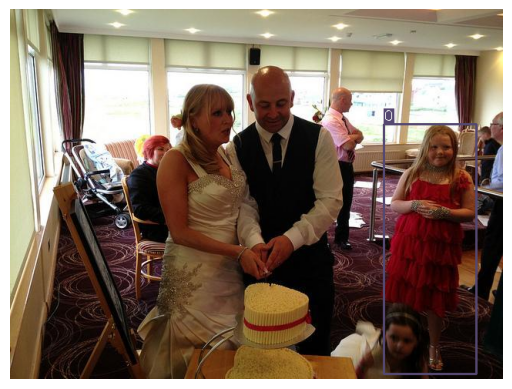

+--------+--------+-----+---------------------+-------------------------------------------------+
| Person | Gender | Age | Emotions categories | Continious emotions (Valence,Arousal,Dominance) |
+--------+--------+-----+---------------------+-------------------------------------------------+
|   0    |   M    |  A  |   ['Anticipation']  |                    [6, 4, 7]                    |
+--------+--------+-----+---------------------+-------------------------------------------------+


In [31]:
image_id = 1    # The id of the image to be displayed
row_example = annotations['train'].iloc[image_id]
display_img_annot(row_example)

path                         emodb_small/ebpsbjqzfhd7efh00i.jpg
orig_db                                             emodb_small
img_size                                             [471, 623]
people                                                        3
bbox          [[47, 161, 616, 468], [177, 11, 570, 471], [20...
label_cat     [[Pain, Sadness, Sensitivity, Suffering], [Sad...
label_cont                    [[2, 7, 4], [2, 3, 4], [2, 4, 2]]
gender                                                [F, M, F]
age                                                   [K, A, K]
Name: 10, dtype: object
[471, 623]
[[47, 161, 616, 468], [177, 11, 570, 471], [200, 182, 344, 471]]
3
The image shape is: (471, 623, 3)
The path of the example image is: C:\Users\arman\Desktop\emotion_recognition\data\interim\images\emodb_small\ebpsbjqzfhd7efh00i.jpg
There is a total of 3 annotated people in the image
The image shape is: (471, 623, 3)


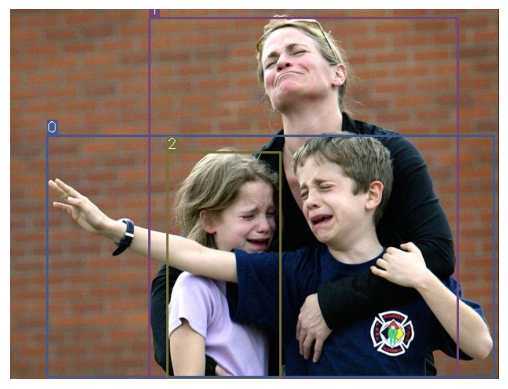

+--------+--------+-----+-------------------------------------------------+-------------------------------------------------+
| Person | Gender | Age |               Emotions categories               | Continious emotions (Valence,Arousal,Dominance) |
+--------+--------+-----+-------------------------------------------------+-------------------------------------------------+
|   0    |   F    |  K  | ['Pain', 'Sadness', 'Sensitivity', 'Suffering'] |                    [2, 7, 4]                    |
|   1    |   M    |  A  |       ['Sadness', 'Suffering', 'Sympathy']      |                    [2, 3, 4]                    |
|   2    |   F    |  K  |         ['Fear', 'Sadness', 'Suffering']        |                    [2, 4, 2]                    |
+--------+--------+-----+-------------------------------------------------+-------------------------------------------------+


In [32]:
import cv2
image_id = 10
# The id of the image to be displayed
row_example = annotations['train'].iloc[image_id]
print(row_example)

print(annotations['train'].iloc[image_id]["img_size"])
photo_directory = os.path.join(INTERIM_DATA_DIR, "images", row_example['path'])
img = cv2.imread(str(photo_directory)) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # Convert BGR to RGB
print(annotations['train'].iloc[image_id]["bbox"])
print(annotations['train'].iloc[image_id]["people"])
print("The image shape is:", img.shape)
display_img_annot(row_example)

### 3.2 Check the given img size are true
From experimenting, we know that emodb_small has inverted the height and width of the images, instead of standard width and height. We will keep in mind this in order to not have problems when making the checks

In [33]:
for data_split in annotations.keys():
    for photo_idx in range(len(annotations[data_split])):
        photo_file = annotations[data_split].loc[photo_idx, 'path']

        original_db = annotations[data_split].loc[photo_idx, 'orig_db']

        if original_db == 'emodb_small':
            height, width  = annotations[data_split].loc[photo_idx, 'img_size']
        else:
            width, height = annotations[data_split].loc[photo_idx, 'img_size']

### 3.3 Check the given bbox are valid

In [34]:
# Define the directory where the photos are located
photo_directory = os.path.join(INTERIM_DATA_DIR, "images")

# Define the list to store not valid photo paths
not_valid_bbox = []
count_too_small = 0
count_too_big = 0
count_too_small_and_big = 0
count_incorrect_order = 0
original_db_count_of_errors = {}

for data_split in annotations.keys():
    for photo_idx in range(len(annotations[data_split])):
        photo_file = annotations[data_split].loc[photo_idx, 'path']

        original_db = annotations[data_split].loc[photo_idx, 'orig_db']

        if original_db == 'emodb_small':
            height, width  = annotations[data_split].loc[photo_idx, 'img_size']
        else:
            width, height = annotations[data_split].loc[photo_idx, 'img_size']

        
        for person in range (len(annotations[data_split].loc[photo_idx, "label_cat"])):
            x1 = annotations[data_split].loc[photo_idx, "bbox"][person][0]; y1 = annotations[data_split].loc[photo_idx, "bbox"][person][1]
            x2 = annotations[data_split].loc[photo_idx, "bbox"][person][2]; y2 = annotations[data_split].loc[photo_idx, "bbox"][person][3]

            if x1 < 0 or y1 < 0 or x2 > width or y2 > height or x1 > x2 or y1 > y2:
                not_valid_bbox.append(photo_file)
                if (x1 < 0 or y1 < 0) and (x2 > width or y2 > height):
                    count_too_small_and_big += 1
                elif x1 < 0 or y1 < 0:
                    count_too_small += 1
                elif x2 > width or y2 > height:
                    count_too_big += 1
                elif x1 > x2 or y1 > y2:
                    count_incorrect_order += 1

                if original_db not in original_db_count_of_errors.keys():
                    original_db_count_of_errors[original_db] = 1
                else:
                    original_db_count_of_errors[original_db] += 1

print("The number of not valid bounding boxes is:", count_too_small+count_too_big+count_incorrect_order+count_too_small_and_big)
print (count_too_small, "\tare too small to 0,0 origin")
print (count_too_big, "\tare too big with respect to the image size")
print (count_too_small_and_big, "\tare too small and too big")
print (count_incorrect_order, "\tare in incorrect relation between x1, x2, y1, y2")

print("\nThe errors comes from the following original databases:")
for key in original_db_count_of_errors.keys():
    print(key, ":", original_db_count_of_errors[key])

The number of not valid bounding boxes is: 400
22 	are too small to 0,0 origin
360 	are too big with respect to the image size
18 	are too small and too big
0 	are in incorrect relation between x1, x2, y1, y2

The errors comes from the following original databases:
emodb_small : 400


### 3.4 Mean color for each categorical emotion
Now we will study if there is any relation between the mean color of the image and the emotion felt. We will compute the mean color for each photo to which is annotated the emotion and plot the results.

First we will compute the mean color for each photo:

In [35]:
import cv2
import numpy as np
import os
from collections import defaultdict

# Define the directory where the photos are located
photo_directory = os.path.join(INTERIM_DATA_DIR, "images")

# Initialize dictionaries to store the sum and count of colors for each emotion
sum_colors = defaultdict(lambda: np.array([0, 0, 0]))
count_colors = defaultdict(int)

for data_split in annotations.keys():
    print("Processing", data_split, "data split:")
    for photo_idx in range(len(annotations[data_split])):
        photo_file = annotations[data_split].loc[photo_idx, 'path']
        
        photo_path = os.path.join(photo_directory, photo_file)
        photo = cv2.imread(photo_path)
        #Convert the image to RGB format
        photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
        # Compute the mean color of the photo
        mean_color = np.mean(photo, axis=(0, 1)).astype(int)
        for person in range (len(annotations[data_split].loc[photo_idx, "label_cat"])):
            emotions = annotations[data_split].loc[photo_idx, "label_cat"][person]
            for emotion in emotions:
                # Acumulate the sum and count of colors for each emotion
                sum_colors[emotion] += mean_color
                count_colors[emotion] += 1
                


        if photo_idx % 1000 == 0:
            print("Processed", photo_idx, "photos")

Processing train data split:
Processed 0 photos
Processed 1000 photos
Processed 2000 photos
Processed 3000 photos
Processed 4000 photos
Processed 5000 photos
Processed 6000 photos
Processed 7000 photos
Processed 8000 photos
Processed 9000 photos
Processed 10000 photos
Processed 11000 photos
Processed 12000 photos
Processed 13000 photos
Processed 14000 photos
Processed 15000 photos
Processed 16000 photos
Processed 17000 photos
Processing val data split:
Processed 0 photos
Processed 1000 photos
Processed 2000 photos
Processing test data split:
Processed 0 photos
Processed 1000 photos
Processed 2000 photos
Processed 3000 photos
Processed 4000 photos


In [36]:
mean_colors = {}
for emotion in sum_colors.keys():
    mean_colors[emotion] = sum_colors[emotion] / count_colors[emotion]

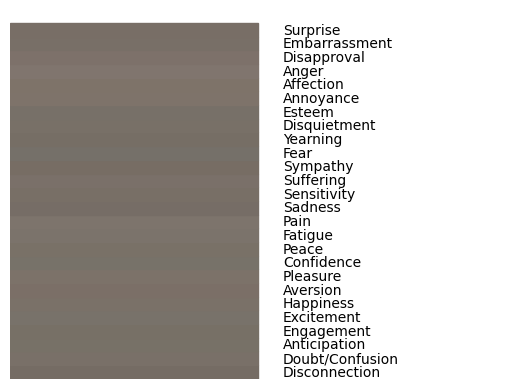

In [37]:
import matplotlib.pyplot as plt
# Create a figure and a subplot
fig, ax = plt.subplots()

# For each emotion, create a patch with the mean color and add it to the plot
for i, emotion in enumerate(mean_colors.keys()):
    if emotion != 'NA':
        ax.add_patch(plt.Rectangle((0, i), 1, 1, color=np.array(mean_colors[emotion])/255))
        ax.text(1.1, i+0.5, emotion, va='center')

# Set the limits and hide the axes
ax.set_xlim(0, 2)
ax.set_ylim(0, len(mean_colors)) # The number of emotions without NA
ax.axis('off')

plt.show()

Now we repeat but for each person (not whole image):


In [44]:
import cv2
import numpy as np
import os
from collections import defaultdict

# Define the directory where the photos are located
photo_directory = os.path.join(INTERIM_DATA_DIR, "images")

# Initialize dictionaries to store the sum and count of colors for each emotion
sum_colors = defaultdict(lambda: np.array([0, 0, 0], dtype=np.int64))
count_colors = defaultdict(int)

for data_split in annotations.keys():
    print("Processing", data_split, "data split:")
    for photo_idx in range(len(annotations[data_split])):
        photo_file = annotations[data_split].loc[photo_idx, 'path']
        
        photo_path = os.path.join(photo_directory, photo_file)
        photo = cv2.imread(photo_path)
        #Convert the image to RGB format
        photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
        for person in range (len(annotations[data_split].loc[photo_idx, "label_cat"])):
            x1 = annotations[data_split].loc[photo_idx, "bbox"][person][0]; y1 = annotations[data_split].loc[photo_idx, "bbox"][person][1]
            x2 = annotations[data_split].loc[photo_idx, "bbox"][person][2]; y2 = annotations[data_split].loc[photo_idx, "bbox"][person][3]

            # Correct the bounding box if outside the image limits
            if x1 < 0: x1 = 0
            if y1 < 0: y1 = 0
            if x2 > photo.shape[1]: x2 = photo.shape[1]
            if y2 > photo.shape[0]: y2 = photo.shape[0]

            mean_color = np.mean(photo[y1:y2,x1:x2], axis=(0, 1)).astype(int)
            emotions = annotations[data_split].loc[photo_idx, "label_cat"][person]
            for emotion in emotions:
                # Acumulate the sum and count of colors for each emotion
                sum_colors[emotion] += mean_color
                count_colors[emotion] += 1
                
        if photo_idx % 1000 == 0:
            print("Processed", photo_idx, "photos")

Processing train data split:
Processed 0 photos
Processed 1000 photos
Processed 2000 photos
Processed 3000 photos
Processed 4000 photos
Processed 5000 photos
Processed 6000 photos
Processed 7000 photos
Processed 8000 photos
Processed 9000 photos
Processed 10000 photos
Processed 11000 photos
Processed 12000 photos
Processed 13000 photos
Processed 14000 photos
Processed 15000 photos
Processed 16000 photos
Processed 17000 photos
Processing val data split:
Processed 0 photos
Processed 1000 photos
Processed 2000 photos
Processing test data split:
Processed 0 photos
Processed 1000 photos
Processed 2000 photos
Processed 3000 photos
Processed 4000 photos


In [53]:
mean_colors = {}
total_sum = np.array([0, 0, 0], dtype=np.int64)
total_count = 0
for emotion in sum_colors.keys():
    mean_colors[emotion] = sum_colors[emotion] / count_colors[emotion]
    total_sum += sum_colors[emotion]
    total_count += count_colors[emotion]
mean_color = total_sum / total_count

In [46]:
print('The mean color for each emotion is:', mean_colors)
print('The count of colors for each emotion is:', sum_colors)

The mean color for each emotion is: {'Disconnection': array([106.32575973,  95.04203351,  89.16813405]), 'Doubt/Confusion': array([111.05863039,  99.67682927,  93.70403377]), 'Anticipation': array([111.08501612, 101.5272357 ,  94.92457153]), 'Engagement': array([110.71894495, 100.15417431,  93.4266055 ]), 'Excitement': array([114.10451378, 104.3837221 ,  97.79985863]), 'Happiness': array([114.61955956, 102.07837697,  95.26790359]), 'Aversion': array([117.13065327, 102.89949749,  95.88777219]), 'Pleasure': array([116.7633191 , 103.63170596,  96.40115092]), 'Confidence': array([112.78254438, 104.25739645,  97.91684277]), 'Peace': array([112.39871194, 100.32435597,  93.77312646]), 'Fatigue': array([114.67160494, 103.51111111,  97.24115226]), 'Pain': array([120.53106212, 107.96993988, 101.34068136]), 'Sadness': array([111.37927565,  98.90140845,  92.63782696]), 'Sensitivity': array([115.04979253, 102.22406639,  95.89073306]), 'Suffering': array([116.65249267, 103.6744868 ,  97.62170088]), 

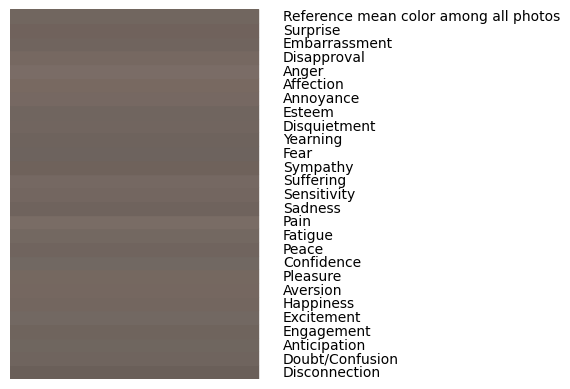

In [55]:
# Create a figure and a subplot
fig, ax = plt.subplots()

# For each emotion, create a patch with the mean color and add it to the plot
for i, emotion in enumerate(mean_colors.keys()):
    if emotion != 'NA':
        ax.add_patch(plt.Rectangle((0, i), 1, 1, color=np.array(mean_colors[emotion])/255))
        ax.text(1.1, i+0.5, emotion, va='center')
    else:
        ax.add_patch(plt.Rectangle((0, i), 1, 1, color=mean_color/255))
        ax.text(1.1, i+0.5, "Reference mean color among all photos", va='center')

# Set the limits and hide the axes
ax.set_xlim(0, 2)
ax.set_ylim(0, len(mean_colors))
ax.axis('off')

plt.show()